# Comparação de Modelos de Previsão de Casos de Dengue

Este notebook implementa e compara dois modelos de previsão de séries temporais para casos de dengue: SARIMA e Prophet. O objetivo é avaliar o desempenho de cada abordagem, especialmente em anos com comportamento atípico (ex: 2024), e gerar gráficos para futura integração na dashboard.

## 1. Importação das Bibliotecas Necessárias

Vamos importar as bibliotecas essenciais para manipulação de dados, visualização e modelagem de séries temporais.

In [1]:
# Bibliotecas de manipulação e visualização de dados
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from prophet import Prophet

# Avaliação
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Modelos de séries temporais
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Configurações de visualização
sns.set_theme(style="darkgrid", palette="Set2")

c:\Users\Gabri\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Carregamento e Pré-processamento dos Dados

Carregue o dataset de casos de dengue, faça a limpeza e ajuste o formato para séries temporais.

In [2]:
# Carregando e transformando dados de casos mensais agregados por município e ano

df_raw = pd.read_csv("https://gist.githubusercontent.com/OliveiraGmo/ea2ba75a8f323d8eacbc468587ba1d08/raw/c963094a9e018f8d2e9f5a2170538bd621378d8f/rmvp.csv")

# Meses no padrão do arquivo (português, 3 letras, primeira maiúscula)
meses_pt = ["Jan", "Fev", "Mar", "Abr", "Mai", "Jun", "Jul", "Ago", "Set", "Out", "Nov", "Dez"]

# Transforma de wide para long: cada linha = 1 município, 1 mês, 1 ano
df_long = df_raw.melt(
    id_vars=["Município de notificação", "Codigo Município", "Ano"],
    value_vars=meses_pt,
    var_name="mes",
    value_name="casos",
)

# Cria coluna de data no formato YYYY-MM
mes_num = {nome: str(i + 1).zfill(2) for i, nome in enumerate(meses_pt)}
df_long["mes_num"] = df_long["mes"].map(mes_num)
df_long["data"] = pd.to_datetime(df_long["Ano"].astype(str) + "-" + df_long["mes_num"] + "-01")

# Agrega total de casos por mês (todos municípios)
df = df_long.groupby("data", as_index=False)["casos"].sum()

# Visualização rápida
df.head()

,data,casos
0,2007-01-01,38
1,2007-02-01,107
2,2007-03-01,521
3,2007-04-01,787
4,2007-05-01,638


## 3. Implementação do Modelo 1: SARIMA

Vamos configurar e ajustar um modelo SARIMA para a série temporal de casos de dengue.

In [3]:
# Separando treino e teste (ex: últimos 12 meses para teste)
train = df.iloc[:-12].copy()
test = df.iloc[-12:].copy()

# Ajustando SARIMA (parâmetros exemplo, ajuste conforme necessário)
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)

sarima = SARIMAX(train["casos"], order=order, seasonal_order=seasonal_order)
sarima_fit = sarima.fit(disp=False)

# Previsão
sarima_pred = sarima_fit.predict(start=test.index[0], end=test.index[-1], dynamic=False)

# Avaliação
sarima_rmse = np.sqrt(mean_squared_error(test["casos"], sarima_pred))
sarima_mae = mean_absolute_error(test["casos"], sarima_pred)

print(f"RMSE SARIMA: {sarima_rmse:.2f}")
print(f"MAE SARIMA: {sarima_mae:.2f}")

RMSE SARIMA: 31256.03
MAE SARIMA: 19366.49


c:\Users\Gabri\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## 4. Treinamento e Avaliação do Modelo 1

Visualize as previsões do SARIMA comparadas aos dados reais.

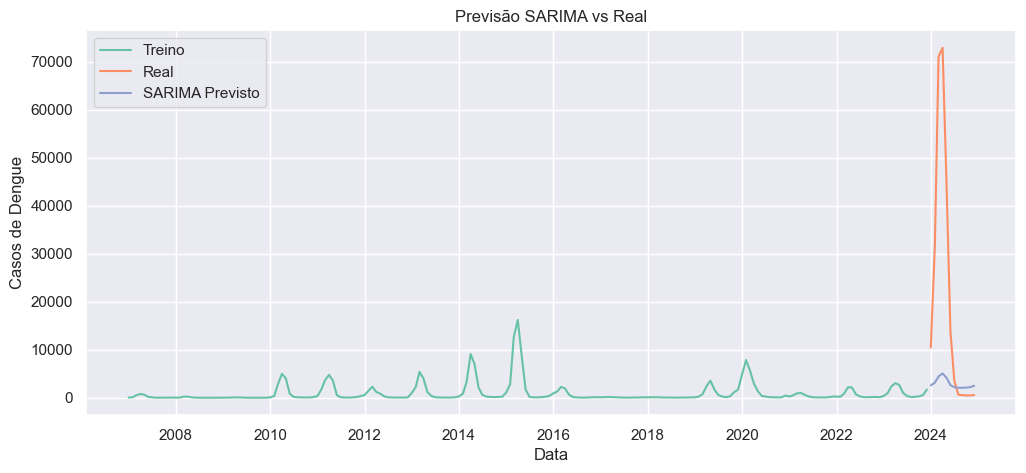

In [4]:
plt.figure(figsize=(12, 5))
plt.plot(train["data"], train["casos"], label="Treino")
plt.plot(test["data"], test["casos"], label="Real")
plt.plot(test["data"], sarima_pred, label="SARIMA Previsto")
plt.title("Previsão SARIMA vs Real")
plt.xlabel("Data")
plt.ylabel("Casos de Dengue")
plt.legend()
plt.show()

## 5. Implementação do Modelo 2: Prophet

Agora, vamos configurar e ajustar o modelo Prophet para a mesma série temporal.

In [5]:
# Prophet exige colunas 'ds' (data) e 'y' (valor)
df_prophet = df.rename(columns={"data": "ds", "casos": "y"})
train_p = df_prophet.iloc[:-12]
test_p = df_prophet.iloc[-12:]

prophet = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
prophet.fit(train_p)

# Troca freq='M' por freq='ME' para evitar FutureWarning
future = prophet.make_future_dataframe(periods=12, freq="ME")
forecast = prophet.predict(future)

# Previsão apenas para o período de teste
prophet_pred = forecast.iloc[-12:]["yhat"].values

# Avaliação
prophet_rmse = np.sqrt(mean_squared_error(test_p["y"], prophet_pred))
prophet_mae = mean_absolute_error(test_p["y"], prophet_pred)

print(f"RMSE Prophet: {prophet_rmse:.2f}")
print(f"MAE Prophet: {prophet_mae:.2f}")

15:44:05 - cmdstanpy - INFO - Chain [1] start processing
15:44:05 - cmdstanpy - INFO - Chain [1] done processing


RMSE Prophet: 32358.12
MAE Prophet: 20055.31


## 6. Treinamento e Avaliação do Modelo 2

Visualize as previsões do Prophet comparadas aos dados reais.

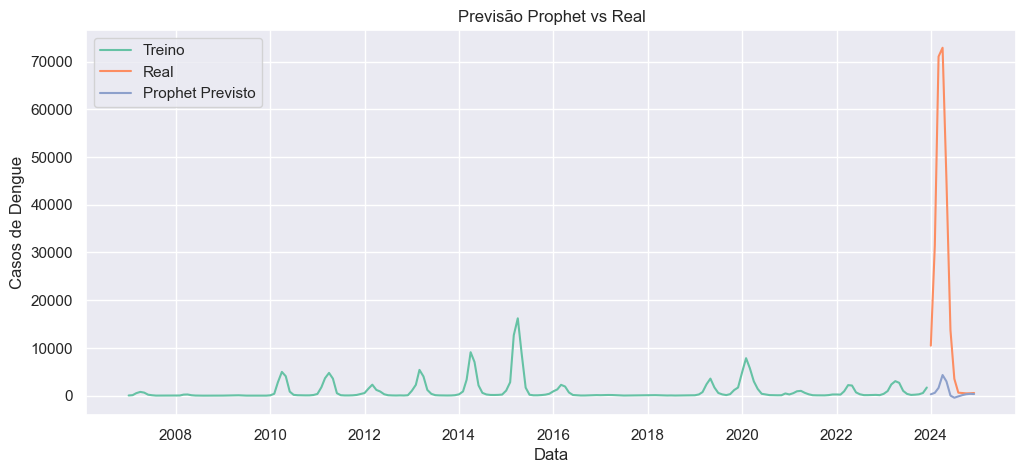

In [6]:
plt.figure(figsize=(12, 5))
plt.plot(train_p["ds"], train_p["y"], label="Treino")
plt.plot(test_p["ds"], test_p["y"], label="Real")
plt.plot(test_p["ds"], prophet_pred, label="Prophet Previsto")
plt.title("Previsão Prophet vs Real")
plt.xlabel("Data")
plt.ylabel("Casos de Dengue")
plt.legend()
plt.show()

## 7. Geração de Gráficos para Dashboard

Compare graficamente os resultados dos dois modelos e prepare visualizações para integração na dashboard.

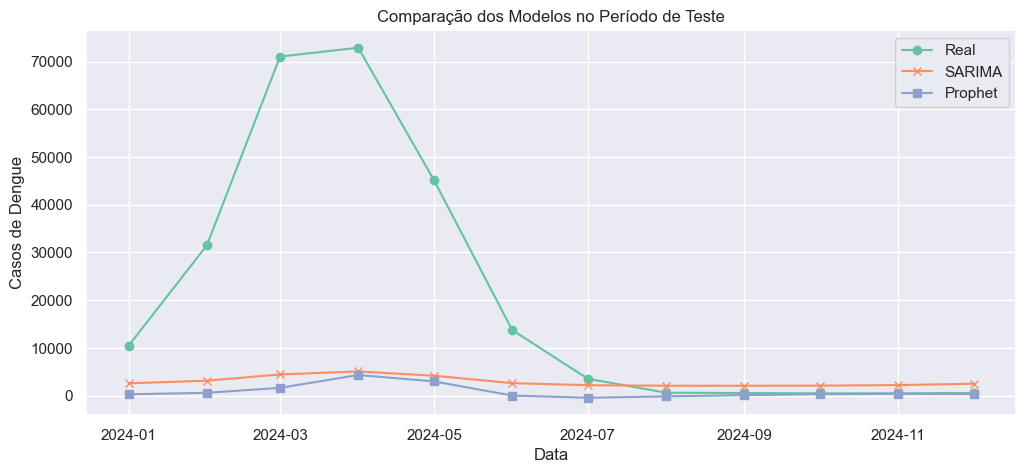

Métricas de desempenho no período de teste:
SARIMA - RMSE: 31256.03, MAE: 19366.49
Prophet - RMSE: 32358.12, MAE: 20055.31


In [7]:
# Comparação dos modelos no período de teste
plt.figure(figsize=(12, 5))
plt.plot(test["data"], test["casos"], label="Real", marker="o")
plt.plot(test["data"], sarima_pred, label="SARIMA", marker="x")
plt.plot(test_p["ds"], prophet_pred, label="Prophet", marker="s")
plt.title("Comparação dos Modelos no Período de Teste")
plt.xlabel("Data")
plt.ylabel("Casos de Dengue")
plt.legend()
plt.show()

# Tabela de métricas
print("Métricas de desempenho no período de teste:")
print(f"SARIMA - RMSE: {sarima_rmse:.2f}, MAE: {sarima_mae:.2f}")
print(f"Prophet - RMSE: {prophet_rmse:.2f}, MAE: {prophet_mae:.2f}")

## 8. Implementação do Modelo 3: Random Forest Regressor

Agora, vamos aplicar um modelo de aprendizado de máquina supervisionado (Random Forest) para previsão dos casos de dengue, incluindo engenharia de features para capturar padrões temporais e lidar com o ano atípico de 2024.

In [8]:
from sklearn.ensemble import RandomForestRegressor

# Engenharia de features temporais
rf_df = df.copy()
rf_df["ano"] = rf_df["data"].dt.year
rf_df["mes"] = rf_df["data"].dt.month
rf_df["mes_sin"] = np.sin(2 * np.pi * rf_df["mes"] / 12)
rf_df["mes_cos"] = np.cos(2 * np.pi * rf_df["mes"] / 12)
rf_df["is_2024"] = (rf_df["ano"] == 2024).astype(int)

# Separando treino e teste
X = rf_df[["ano", "mes", "mes_sin", "mes_cos", "is_2024"]]
y = rf_df["casos"]
X_train, X_test = X.iloc[:-12], X.iloc[-12:]
y_train, y_test = y.iloc[:-12], y.iloc[-12:]

# Treinando o modelo
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Previsão
y_pred_rf = rf.predict(X_test)

# Avaliação
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_mae = mean_absolute_error(y_test, y_pred_rf)

print(f"RMSE Random Forest: {rf_rmse:.2f}")
print(f"MAE Random Forest: {rf_mae:.2f}")

RMSE Random Forest: 32524.76
MAE Random Forest: 19983.87


In [9]:
rf_df["data"].iloc[-12:]

204   2024-01-01
205   2024-02-01
206   2024-03-01
207   2024-04-01
208   2024-05-01
209   2024-06-01
210   2024-07-01
211   2024-08-01
212   2024-09-01
213   2024-10-01
214   2024-11-01
215   2024-12-01
Name: data, dtype: datetime64[ns]

## 9. Avaliação e Visualização do Random Forest

Visualize as previsões do Random Forest comparadas aos dados reais e aos outros modelos.

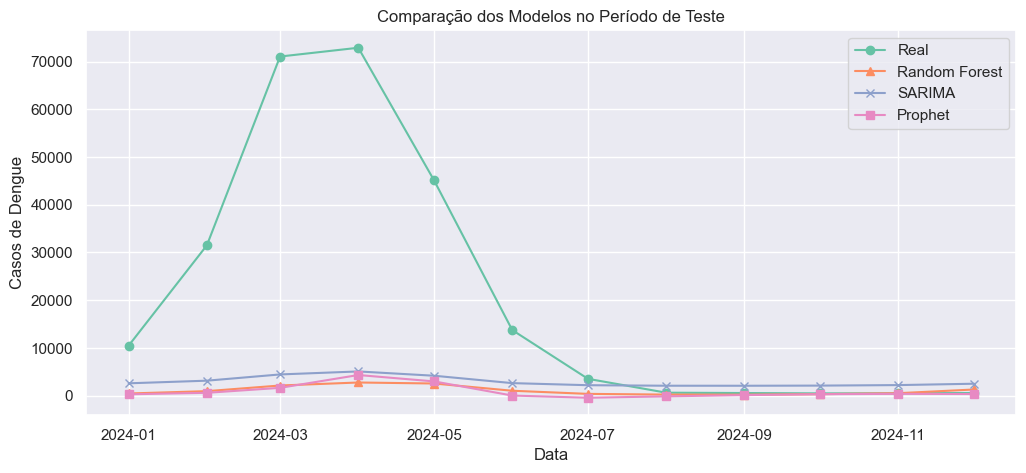

Métricas de desempenho no período de teste:
SARIMA - RMSE: 31256.03, MAE: 19366.49
Prophet - RMSE: 32358.12, MAE: 20055.31
Random Forest - RMSE: 32524.76, MAE: 19983.87


In [10]:
plt.figure(figsize=(12, 5))
plt.plot(rf_df["data"].iloc[-12:], y_test, label="Real", marker="o")
plt.plot(rf_df["data"].iloc[-12:], y_pred_rf, label="Random Forest", marker="^")
plt.plot(test["data"], sarima_pred, label="SARIMA", marker="x")
plt.plot(test_p["ds"], prophet_pred, label="Prophet", marker="s")
plt.title("Comparação dos Modelos no Período de Teste")
plt.xlabel("Data")
plt.ylabel("Casos de Dengue")
plt.legend()
plt.show()

# Tabela de métricas
print("Métricas de desempenho no período de teste:")
print(f"SARIMA - RMSE: {sarima_rmse:.2f}, MAE: {sarima_mae:.2f}")
print(f"Prophet - RMSE: {prophet_rmse:.2f}, MAE: {prophet_mae:.2f}")
print(f"Random Forest - RMSE: {rf_rmse:.2f}, MAE: {rf_mae:.2f}")

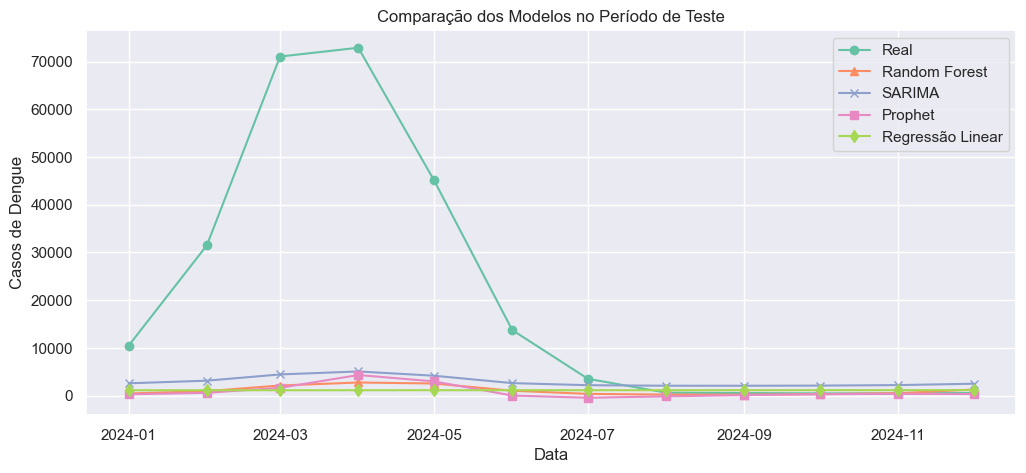

Métricas de desempenho no período de teste:
SARIMA - RMSE: 31256.03, MAE: 19366.49
Prophet - RMSE: 32358.12, MAE: 20055.31
Random Forest - RMSE: 32524.76, MAE: 19983.87
Regressão Linear - RMSE: 33106.78, MAE: 20286.29


In [11]:
# Regressão Linear Simples para comparação
from sklearn.linear_model import LinearRegression

# Feature: número sequencial do mês desde o início da série
lr_df = df.copy()
lr_df["mes"] = lr_df["data"].dt.month
lr_df["ano"] = lr_df["data"].dt.year
lr_df["mes_seq"] = (lr_df["ano"] - lr_df["ano"].min()) * 12 + (lr_df["mes"] - 1)

# Separando treino e teste (últimos 12 meses para teste)
X_lr = lr_df[["mes_seq"]]
y_lr = lr_df["casos"]
X_train_lr, X_test_lr = X_lr.iloc[:-12], X_lr.iloc[-12:]
y_train_lr, y_test_lr = y_lr.iloc[:-12], y_lr.iloc[-12:]

# Treinando o modelo de regressão linear
lr = LinearRegression()
lr.fit(X_train_lr, y_train_lr)

# Previsão
y_pred_lr = lr.predict(X_test_lr)

# Avaliação
lr_rmse = np.sqrt(mean_squared_error(y_test_lr, y_pred_lr))
lr_mae = mean_absolute_error(y_test_lr, y_pred_lr)

plt.figure(figsize=(12, 5))
plt.plot(rf_df["data"].iloc[-12:], y_test, label="Real", marker="o")
plt.plot(rf_df["data"].iloc[-12:], y_pred_rf, label="Random Forest", marker="^")
plt.plot(test["data"], sarima_pred, label="SARIMA", marker="x")
plt.plot(test_p["ds"], prophet_pred, label="Prophet", marker="s")
plt.plot(lr_df["data"].iloc[-12:], y_pred_lr, label="Regressão Linear", marker="d")
plt.title("Comparação dos Modelos no Período de Teste")
plt.xlabel("Data")
plt.ylabel("Casos de Dengue")
plt.legend()
plt.show()

# Tabela de métricas
print("Métricas de desempenho no período de teste:")
print(f"SARIMA - RMSE: {sarima_rmse:.2f}, MAE: {sarima_mae:.2f}")
print(f"Prophet - RMSE: {prophet_rmse:.2f}, MAE: {prophet_mae:.2f}")
print(f"Random Forest - RMSE: {rf_rmse:.2f}, MAE: {rf_mae:.2f}")
print(f"Regressão Linear - RMSE: {lr_rmse:.2f}, MAE: {lr_mae:.2f}")

## XGBoost para Previsão de Casos de Dengue
Este bloco treina e avalia o modelo XGBoost, comparando seu desempenho com os demais modelos.

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

# Engenharia de atributos para XGBoost
for df_ in [train, test]:
    if "mes" not in df_.columns:
        df_.loc[:, "mes"] = df_["data"].dt.month
    if "ano" not in df_.columns:
        df_.loc[:, "ano"] = df_["data"].dt.year
    if "mes_sin" not in df_.columns:
        df_.loc[:, "mes_sin"] = np.sin(2 * np.pi * df_["mes"] / 12)
    if "mes_cos" not in df_.columns:
        df_.loc[:, "mes_cos"] = np.cos(2 * np.pi * df_["mes"] / 12)
    if "is_2024" not in df_.columns:
        df_.loc[:, "is_2024"] = (df_["ano"] == 2024).astype(int)

# Seleção de features para o XGBoost
features_xgb = [
    col
    for col in train.columns
    if col not in ["casos", "data", "Ano", "ano", "Mes", "mes"] and train[col].dtype != "O"
]
if not features_xgb:
    raise ValueError(
        "Nenhuma feature disponível para o XGBoost! Verifique a engenharia de atributos."
    )

# Treinamento e previsão
xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(train[features_xgb], train["casos"])
xgb_pred = xgb.predict(test[features_xgb])

# Avaliação
xgb_mae = mean_absolute_error(test["casos"], xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(test["casos"], xgb_pred))
print(f"XGBoost MAE: {xgb_mae:.2f}")
print(f"XGBoost RMSE: {xgb_rmse:.2f}")

XGBoost MAE: 19967.70
XGBoost RMSE: 32379.56


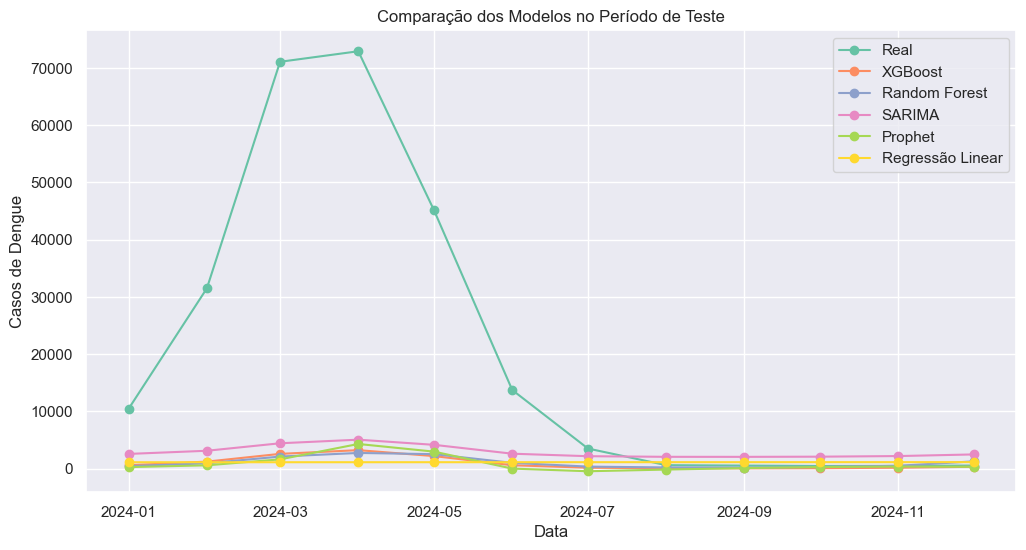

In [13]:
# Comparação visual: XGBoost vs outros modelos
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(test["data"], test["casos"], label="Real", marker="o")
plt.plot(test["data"], xgb_pred, label="XGBoost", marker="o")
plt.plot(test["data"], y_pred_rf, label="Random Forest", marker="o")
plt.plot(test["data"], sarima_pred, label="SARIMA", marker="o")
plt.plot(test["data"], prophet_pred, label="Prophet", marker="o")
plt.plot(test["data"], y_pred_lr, label="Regressão Linear", marker="o")
plt.title("Comparação dos Modelos no Período de Teste")
plt.xlabel("Data")
plt.ylabel("Casos de Dengue")
plt.legend()
plt.grid(True)
plt.show()

## MLP (Perceptron Multicamadas)

O Perceptron Multicamadas (MLP) é uma rede neural feedforward clássica, útil para capturar relações não-lineares em séries temporais. Aqui, utilizamos uma arquitetura simples para prever casos de dengue mensais.

In [14]:
# Preparação dos dados para o MLP
from sklearn.preprocessing import StandardScaler

X_train_mlp = X_train.copy()
X_test_mlp = X_test.copy()
scaler = StandardScaler()
X_train_mlp_scaled = scaler.fit_transform(X_train_mlp)
X_test_mlp_scaled = scaler.transform(X_test_mlp)

In [15]:
# Importações corrigidas
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

mlp = Sequential(
    [
        Dense(64, activation="relu", input_shape=(X_train_mlp_scaled.shape[1],)),
        Dense(32, activation="relu"),
        Dense(1, activation="linear"),
    ]
                )
mlp.compile(optimizer="adam", loss="mse")
mlp.fit(X_train_mlp_scaled, y_train, epochs=100, batch_size=16, verbose=0)

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# Avaliação do MLP
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred_mlp = mlp.predict(X_test_mlp_scaled).flatten()
mlp_mae = mean_absolute_error(y_test, y_pred_mlp)
mlp_rmse = np.sqrt(mean_squared_error(y_test, y_pred_mlp))
print(f"MAE: {mlp_mae:.2f}")
print(f"RMSE: {mlp_rmse:.2f}")

NameError: name 'mlp' is not defined

In [16]:
import matplotlib.pyplot as plt

# Previsão para 2025 com o MLP
# Garante que as colunas de future_X sejam as mesmas do treino e preenche faltantes com 0
# Geração de variáveis para previsão de 2025
# Cria datas futuras para 2025
import pandas as pd

# Última data do dataframe
last_date = df["data"].max()
# Gera 12 meses seguintes
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq="MS")

# Cria DataFrame de features futuras com mesma engenharia do treino
future_X = pd.DataFrame(
    {
        "ano": future_dates.year,
        "mes": future_dates.month,
        "mes_sin": np.sin(2 * np.pi * future_dates.month / 12),
        "mes_cos": np.cos(2 * np.pi * future_dates.month / 12),
        "is_2024": (future_dates.year == 2024).astype(int),
        "is_2025": (future_dates.year == 2025).astype(int),  # caso o modelo use
    }
)


future_X_corrigido = future_X.reindex(columns=X_train_mlp.columns, fill_value=0)
future_X_scaled = scaler.transform(future_X_corrigido)
y_pred_mlp_2025 = mlp.predict(future_X_scaled).flatten()

plt.figure(figsize=(10, 4))
plt.plot(df["data"], df["casos"], label="Observado")
plt.plot(future_dates, y_pred_mlp_2025, label="MLP - Previsão 2025", linestyle="--")
plt.title("Previsão de Casos de Dengue - MLP")
plt.legend()
plt.show()

NameError: name 'mlp' is not defined

## LSTM (Long Short-Term Memory)

A LSTM é uma arquitetura de rede neural recorrente projetada para aprender dependências de longo prazo em séries temporais. Aqui, aplicamos uma LSTM simples para prever casos de dengue mensais.

In [17]:
# Preparação dos dados para LSTM
import numpy as np
from sklearn.preprocessing import StandardScaler

n_lags = 12
series = df["casos"].values
scaler_lstm = StandardScaler()
series_scaled = scaler_lstm.fit_transform(series.reshape(-1, 1)).flatten()


def create_lagged_sequences(series, n_lags):
    X, y = [], []
    for i in range(n_lags, len(series)):
        X.append(series[i - n_lags : i])
        y.append(series[i])
    return np.array(X), np.array(y)


X_lstm, y_lstm = create_lagged_sequences(series_scaled, n_lags)
X_train_lstm, X_test_lstm = X_lstm[:-12], X_lstm[-12:]
y_train_lstm, y_test_lstm = y_lstm[:-12], y_lstm[-12:]

In [18]:
# Treinamento do modelo LSTM
from keras.layers import LSTM, Dense, Input
from keras.models import Sequential

X_train_lstm_reshaped = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm_reshaped = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

lstm_model = Sequential([Input(shape=(n_lags, 1)), LSTM(32, activation="tanh"), Dense(1)])
lstm_model.compile(optimizer="adam", loss="mse")
lstm_model.fit(X_train_lstm_reshaped, y_train_lstm, epochs=100, batch_size=8, verbose=0)
y_pred_lstm = lstm_model.predict(X_test_lstm_reshaped).flatten()
lstm_mae = mean_absolute_error(y_test_lstm, y_pred_lstm)
lstm_rmse = np.sqrt(mean_squared_error(y_test_lstm, y_pred_lstm))
print(f"MAE: {lstm_mae:.2f}")
print(f"RMSE: {lstm_rmse:.2f}")

ModuleNotFoundError: No module named 'keras'

In [19]:
# Previsão para 2025 com LSTM
future_series = np.concatenate([series_scaled, np.zeros(12)])
lstm_preds_2025 = []
input_lstm = future_series[-(12 + 12) : -12].copy()
for i in range(12):
    pred = lstm_model.predict(input_lstm.reshape(1, n_lags, 1)).flatten()[0]
    lstm_preds_2025.append(pred)
    input_lstm = np.roll(input_lstm, -1)
    input_lstm[-1] = pred
lstm_preds_2025 = scaler_lstm.inverse_transform(np.array(lstm_preds_2025).reshape(-1, 1)).flatten()
last_date = df["data"].max()
future_dates_lstm = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq="MS")

plt.figure(figsize=(10, 4))
plt.plot(df["data"], df["casos"], label="Observado")
plt.plot(future_dates_lstm, lstm_preds_2025, label="LSTM - Previsão 2025", linestyle="--")
plt.title("Previsão de Casos de Dengue - LSTM")
plt.legend()
plt.show()

NameError: name 'lstm_model' is not defined